## Chromaffin dataset - $\kappa$-velo

**In this Notebook we will be applying $\kappa$-velo on the chromaffin dataset. This dataset was originally published by Furlan et al. (https://doi.org/10.1126/science.aal3753). The dataset was used for RNA velocity for the first time by La Manno et al. (https://doi.org/10.1038/s41586-018-0414-6). This dataset was generated using SMART-seq2 and shows mouse Schwann cell precursors (SCPs) differentiating into chromaffin cells.** 

In [1]:
### load libraries

# standard libraries
import numpy as np
import pandas as pd

# single-cell libraries
import anndata as ad
import scanpy as sc

# plotting libraries
import matplotlib.pyplot as plt

# dimension reductions
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
import umap
from scipy.spatial import cKDTree 

# import our own functions
from velocity.processing.filtering import *
from velocity.processing.imputation import *
from velocity.processing.normalisation import *

from velocity.tools.prior import *
from velocity.tools.filtering import *
from velocity.tools.fit import *

from velocity.visualisation.pretty_plotting import *
from velocity.visualisation.vis import *

### Load dataset
Here, we load the spliced and unspliced matrices from the original dataset, as well as the original clusters, colours and t-SNE embedding. All of the files used here can be downloaded from this webpage: http://pklab.med.harvard.edu/velocyto/notebooks/R/chromaffin2.nb.html (a tutorial on velocyto provided by La Manno and the Karchenko lab). The original file name is `onefilepercell_A1_unique_and_others_J2CH1.loom `, which we renamed to `chromaffin.loom`. The files with the cell colors/clusters (`cell_colors.csv`) and the t-SNE embedding (`embedding.csv`) can be found on this GitHub page under datasets/chromaffin.

In [2]:
### load chromaffin dataset
chromaffin_path = "../datasets/chromaffin/chromaffin.loom"
adata = ad.read_loom(chromaffin_path)

In [3]:
### make obs names shorter
new_names = []

for obs_name_idx in range(len(adata.obs_names)):
    obs_name = adata.obs_names[obs_name_idx]
    new_name = obs_name.replace("onefilepercell_A1_unique_and_others_J2CH1:", "")
    new_name = new_name.replace("_unique.bam", "")
    new_names.append(new_name)

adata.obs_names = new_names

In [4]:
### add clusters from original publication
clusters_path ="../datasets/chromaffin/cell_colors.csv"
clusters = pd.read_csv(clusters_path, index_col=0)
adata = adata[clusters.index,:]
adata.obs["clusters"] = clusters

Trying to set attribute `.obs` of view, copying.


In [5]:
### set correct names and colours to clusters
cluster_names = {'#00FF66FF':'0','#0066FFFF':'1','#CC00FFFF':'2','#CCFF00FF':'3','#FF0000FF':'4'}
adata.obs['clusters'] = (adata.obs['clusters'].map(cluster_names).astype('category'))
adata.uns['clusters_colors'] = ['#00FF66FF','#0066FFFF','#CC00FFFF','#CCFF00FF','#FF0000FF']

In [6]:
### add embedding from original publication
embedding_path = "../datasets/chromaffin/embedding.csv"
embedding = pd.read_csv(embedding_path, index_col=0)
adata = adata[embedding.index,:]
adata.obsm["X_tsne"] = embedding
adata.obsm["X_tsne"] = np.array(adata.obsm["X_tsne"])

... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


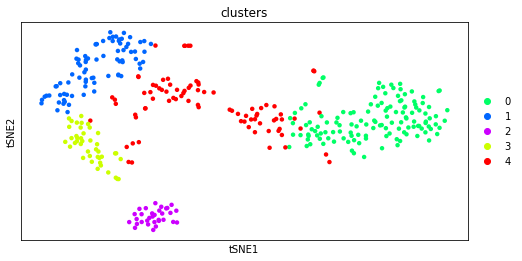

In [7]:
### plot dataset
fig, axs = plt.subplots(1, 1, figsize=(8, 4), frameon=False)
sc.pl.tsne(adata, color="clusters", s=80, ax=axs)

In [8]:
adata

AnnData object with n_obs × n_vars = 369 × 23420
    obs: 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'matrix', 'ambiguous', 'spanning', 'spliced', 'unspliced'

### Processing
Here, we will process the data according to the $\kappa$-velo workflow. We will select the highly variable genes (HVGs), filter for genes with sufficient unspliced an spliced counts, L1 normalise the data, and last we impute the data. If you are interested in learning more about each individual step we recommend to have a look at Supplementary Note 5 in our manuscript.

In [9]:
### convert matrices from sparse to dense
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

In [10]:
### select HVGs
hvgs = get_hvgs(adata, no_of_hvgs=2000, theta=100, layer='spliced')
print("Subsetting to top " + str(len(hvgs)) + " highly-variable genes.")
adata = adata[:, hvgs]

Subsetting to top 2000 highly-variable genes.


/Users/bbouman/Documents/projects/velocity_package/velocity/processing/filtering.py:28: RuntimeWarning: invalid value encountered in true_divide
  z = (counts - mu) / np.sqrt(mu + (np.square(mu) / theta))


In [11]:
### subset for genes that have high enough U and S counts
minlim = 15
us_genes = get_high_us_genes(adata, minlim_u=minlim, minlim_s=minlim)
print("Subsetting to " + str(len(us_genes)) + " genes with sufficient S and U counts.")
adata = adata[:,us_genes]

Subsetting to 1894 genes with sufficient S and U counts.


In [12]:
### L1 normalise unspliced and spliced together
normalise_layers(adata, mode='combined', norm='L1')

total_counts not given


In [13]:
### imputation
impute_counts(adata, n_neighbours = 15, layer_NN = 'spliced', n_pcs = 15)

### Velocity calculation
To recover the parameters, we will run the function `recover_reaction_rate_pars`. This function takes some time (about 10 minutes) so if you want to save some time you can also just download the recovered parameters from the folder datasets/chromaffin in our GitHub page and add them to the AnnData object. After recovering the parameters we run two additional filtering steps. Last, we use the recovered parameters to calculate the velocities.

In [ ]:
### recover dynamics for selected genes
#recover_reaction_rate_pars(adata, use_raw=False, n=100, key="fit")

In [ ]:
### save recovered parameters
#save_path = "../datasets/chromaffin/adata_var_after_recovery.csv"
#adata.var.to_csv(save_path)

In [14]:
### load recovered parameters
load_path = "../datasets/chromaffin/adata_var_after_recovery.csv"
adata.var = pd.read_csv(load_path, index_col=0)

In [15]:
### remove likelihood genes
likelihood_genes = adata.var['fit_likelihood'].sort_values(ascending=False)
likelihood_genes = likelihood_genes.dropna()
likelihood_genes = likelihood_genes[likelihood_genes > 0.7]
likelihood_genes = likelihood_genes.index.values
print(str(len(likelihood_genes))+" high-likelihood genes kept")
adata = adata[:, likelihood_genes]

606 high-likelihood genes kept


In [16]:
### set prior state on genes (second entry is the cluster preceding the first entry)
connections_dict = {'0': ['4'],
                    '4': ['1'],
                    '2': ['1'],
                    '3': ['1']}

set_prior_state(adata, connections_dict, clusterkey="clusters")

In [17]:
### find all genes where prior state matches the retrieved state
matching_genes = get_matching_state_genes(adata, total_cells=30, perc_cells=5, perc_match=80)
print(str(len(matching_genes))+" prior state matching genes kept")
adata = adata[:, matching_genes]

112 prior state matching genes kept


/Users/bbouman/Documents/projects/velocity_package/velocity/tools/filtering.py:44: RuntimeWarning: invalid value encountered in true_divide
  percentage = (prior_ks == method_ks).sum()/total_cells_with_prior*100


In [18]:
### calculate velocity
get_velocity(adata, use_raw=False, key="fit", normalise=None, scale=True)

Trying to set attribute `.layers` of view, copying.


### Visualisation
Last, we want to visualise our calculated velocities. Here we will calculate a new PCA and UMAP embedding for our data and project the velocities onto the embeddings.

**Calculate PCA embedding**

In [19]:
### scale data (imputed spliced counts)
scal = StandardScaler()
spliced_scaled = scal.fit_transform(adata.layers["Ms"].copy())

In [20]:
### run PCA
np.random.seed(10)
n_pcs = 30
pca = PCA(n_components=n_pcs, random_state=0)
pca.fit(spliced_scaled)
pca_pts = pca.transform(spliced_scaled)

**Calculate future states**

In [21]:
### create future states (spliced counts + velocity)
scale = 3
S_fut = adata.layers["Ms"]+(adata.layers["velocity"]*scale)

In [22]:
### scale the future states in the same way as we scaled S
S_fut_scaled = scal.transform(S_fut)

In [23]:
### apply pre-trained PCA transformation on scaled future states
pca_pts_fut = pca.transform(S_fut_scaled)

In [24]:
### get velocity vector in PCA space
pca_v = pca_pts_fut-pca_pts

In [25]:

#down_scale = 0.1
#pca_v_scaled = pca_v/down_scale

**Create velocity plots - PCA embedding**

In [26]:
### get colors of each cluster
color_dict = dict(zip(adata.obs["clusters"].cat.categories, adata.uns["clusters_colors"]))
cell_colors=adata.obs["clusters"].map(color_dict)
light_color = np.array([lighten_color(i, .3) for i in cell_colors])

In [27]:
kwargs = {"scale": 1, "angles": "xy", "scale_units": "xy", "edgecolors": "k", "linewidth": 0.5, "headwidth": 5, "headaxislength": 4}

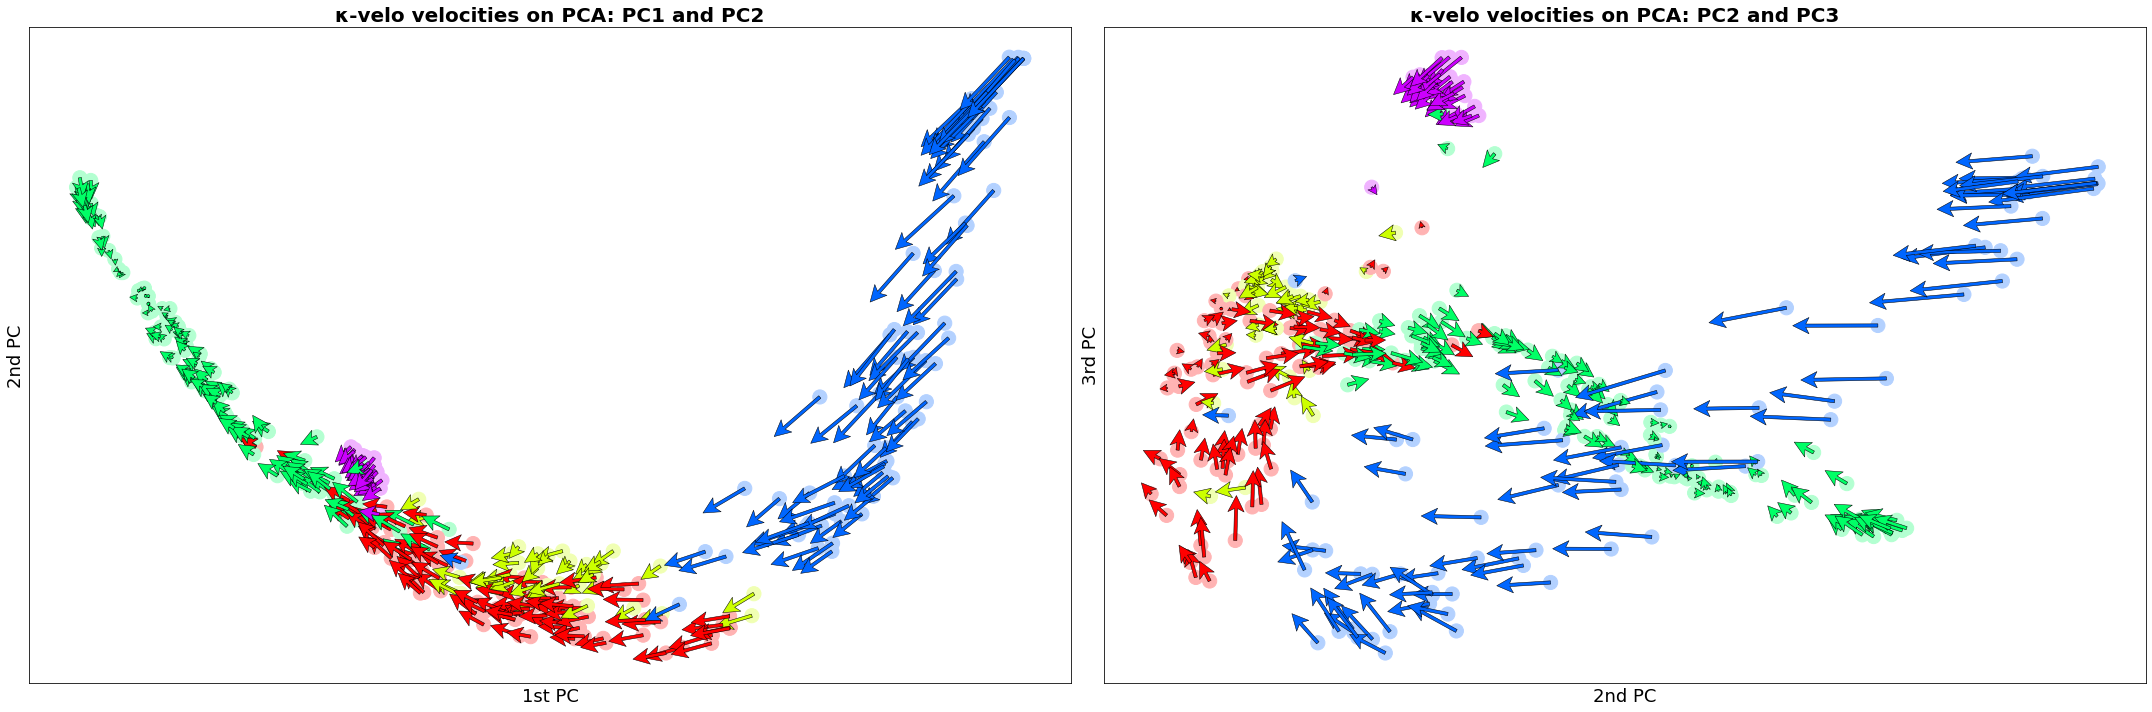

In [28]:
### create PCA plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

# plot points (cells) and arrows (velocities)
axs[0].scatter(pca_pts[:,0], pca_pts[:,1], color=light_color, s=200)
axs[1].scatter(pca_pts[:,1], pca_pts[:,2], color=light_color, s=200)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_facecolor('white')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_facecolor('white')
fig.patch.set_alpha(0)

# axis labels
axs[0].set_xlabel("1st PC", fontsize=18)
axs[0].set_ylabel("2nd PC", fontsize=18)
axs[1].set_xlabel("2nd PC", fontsize=18)
axs[1].set_ylabel("3rd PC", fontsize=18)

# title
axs[0].set_title("κ-velo velocities on PCA: PC1 and PC2", fontsize=20, fontweight="bold")
axs[1].set_title("κ-velo velocities on PCA: PC2 and PC3", fontsize=20, fontweight="bold")

# plot arrows 
axs[0].quiver(pca_pts[:,0], pca_pts[:,1], pca_v[:,0], pca_v[:,1], color=cell_colors, **kwargs)
axs[1].quiver(pca_pts[:,1], pca_pts[:,2], pca_v[:,1], pca_v[:,2], color=cell_colors, **kwargs)

# save plot
plt.tight_layout()
save_path = "../figures/chromaffin/chromaffin_kappa-velo_PCA.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()

**Calculate UMAP embedding**

In [49]:
### calculate UMAP 
reducer = umap.UMAP(random_state=0, n_neighbors=20, min_dist=.7, n_components=2, metric="euclidean")
UMAP_data = reducer.fit_transform(pca_pts)

In [50]:
### calculate velocity projections
n_neighbors = 15
UMAP_fut = nystroem_project(UMAP_data, pca_pts, pca_pts_fut, n_neighbors=n_neighbors,force_no_scale=True)
UMAP_v = UMAP_fut-UMAP_data

Projecting velocities using Nyström approach.


**Smoothen velocities**

In [51]:
### get top 30 nearest neighbors
NN = cKDTree(pca_pts).query(x=pca_pts, k=30, n_jobs=1)[1]

<ipython-input-51-fb12c6d4a1d7>:2: DeprecationWarning: The n_jobs argument has been renamed "workers". The old name "n_jobs" will stop working in SciPy 1.8.0.
  NN = cKDTree(pca_pts).query(x=pca_pts, k=30, n_jobs=1)[1]


In [52]:
### smoothed velocities
UMAP_v_mean = np.nanmean(np.array(UMAP_v)[NN], axis=1)

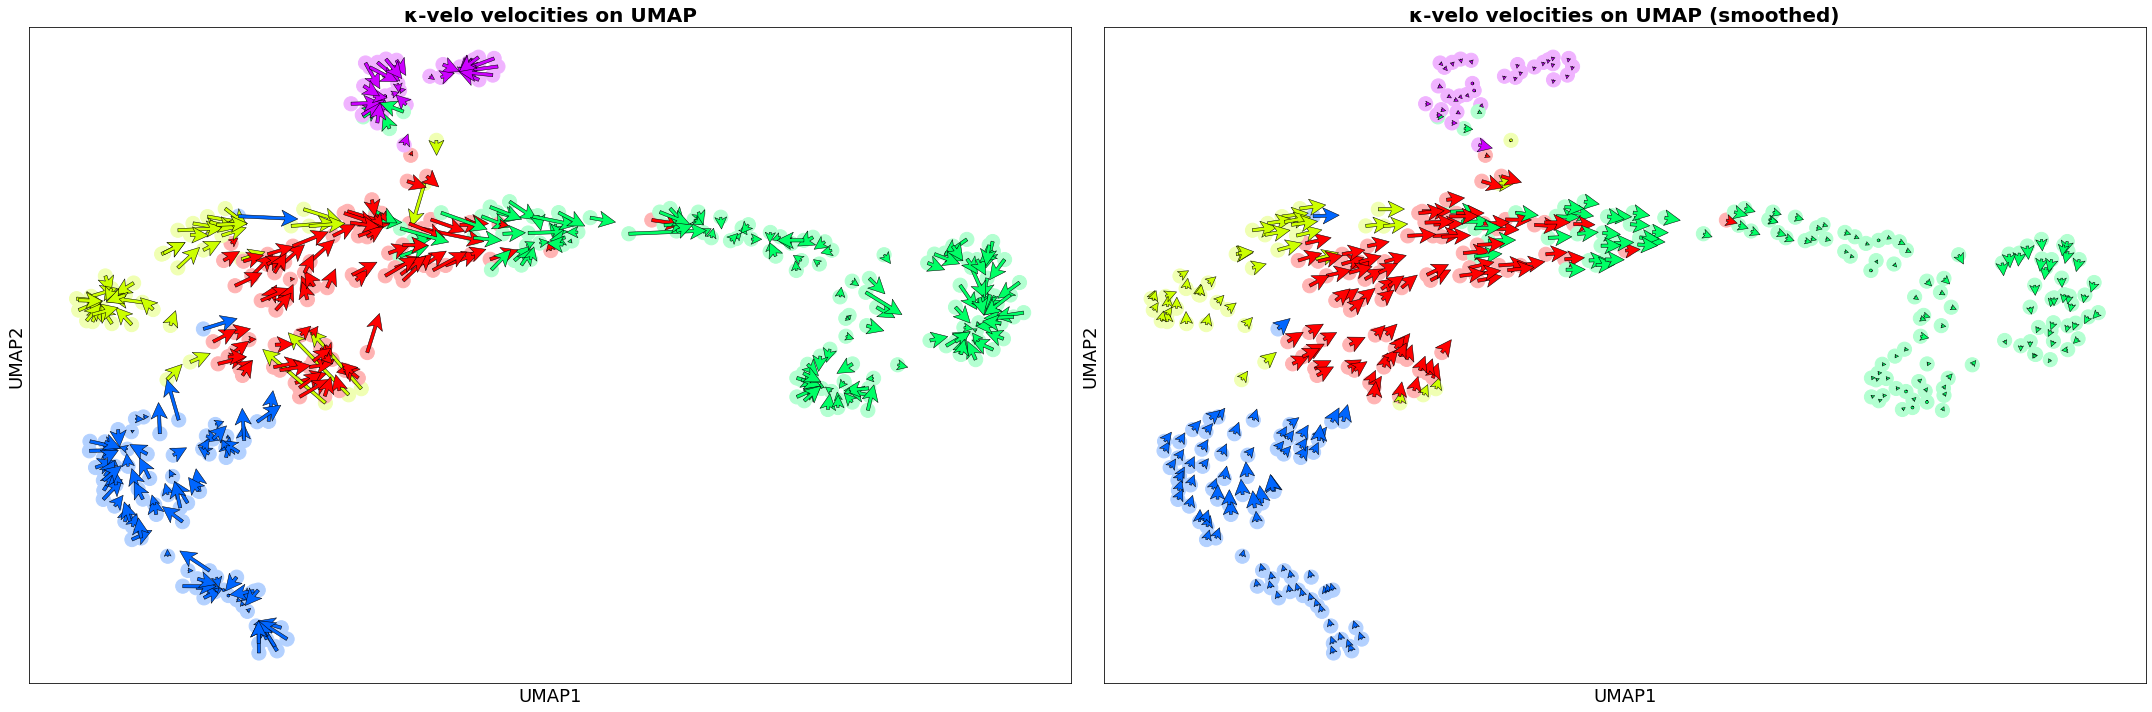

In [53]:
### create UMAP plot of pancreas by kappa-velo
fig, axs = plt.subplots(1, 2, figsize=(30, 10))

axs[0].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=200)
axs[1].scatter(UMAP_data[:,0], UMAP_data[:,1], color=light_color, s=200)

# make pretty
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_facecolor('white')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_facecolor('white')
fig.patch.set_alpha(0)

# axis labels
axs[0].set_xlabel("UMAP1", fontsize=18)
axs[0].set_ylabel("UMAP2", fontsize=18)
axs[1].set_xlabel("UMAP1", fontsize=18)
axs[1].set_ylabel("UMAP2", fontsize=18)

# title
axs[0].set_title("κ-velo velocities on UMAP", fontsize=20, fontweight="bold")
axs[1].set_title("κ-velo velocities on UMAP (smoothed)", fontsize=20, fontweight="bold")

# plot arrows 
axs[0].quiver(UMAP_data[:,0], UMAP_data[:,1], UMAP_v[:,0], UMAP_v[:,1], color=cell_colors, **kwargs)
axs[1].quiver(UMAP_data[:,0], UMAP_data[:,1], UMAP_v_mean[:,0], UMAP_v_mean[:,1], color=cell_colors, **kwargs)

# save plot
plt.tight_layout()
save_path = "../figures/chromaffin/chromaffin_kappa-velo_UMAP.png"
plt.savefig(save_path, dpi=300, transparent=True)

plt.show()